In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#Data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import datetime
import math
from sklearn.preprocessing import LabelEncoder
import statistics
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from itertools import product
from math import sqrt
import json
from sklearn.preprocessing import PolynomialFeatures

#Models
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Dropout,Reshape
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
sample=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

In [3]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
X=train.drop(columns=['Transported'])
y=train['Transported']
# X is Feature, Y is Target

In [5]:
X.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [6]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
dtypes: float64(6), object(7)
memory usage: 883.0+ KB


In [8]:
X.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

In [9]:
nulls=[]
unique=[]

for col in X.columns:
    nulls.append(X[col].isnull().sum())
    unique.append(X[col].nunique())
    
summary=pd.DataFrame(data={'Columns':X.columns,'No of null':nulls,'No of unique values':unique})
summary

,Columns,No of null,No of unique values
0,PassengerId,0,8693
1,HomePlanet,201,3
2,CryoSleep,217,2
3,Cabin,199,6560
4,Destination,182,3
5,Age,179,80
6,VIP,203,2
7,RoomService,181,1273
8,FoodCourt,183,1507
9,ShoppingMall,208,1115


In [10]:
X.corr()

/tmp/ipykernel_32/1968499000.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X.corr()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000


In [11]:
#sns.pairplot(X.select_dtypes(include=['float64']))

First lets split into deck num side 

In [12]:
# I'll check on how to do string formatting
train_deck = [] 
train_count = []
test_deck = [] 
test_count = []

deck = ['Cabin','Value Counts']

# count_decks()
# pd.set_option('display.max_rows', None)

# print(, test['Cabin'].value_counts(), sep ='/t')

# For train

train_deck.append(train['Cabin'])
train_count.append(train['Cabin'].value_counts())
    
summary_train = pd.DataFrame(data = {deck[0] : train_deck , deck[1]: train_count})
print(summary_train)

# For test

test_deck.append(test['Cabin'])
test_count.append(test['Cabin'].value_counts())

summary_test = pd.DataFrame(data = {deck[0]:test_deck, deck[1]: test_count})
summary_test

                                               Cabin  \
0  0          B/0/P
1          F/0/S
2          A...   

                                        Value Counts  
0  G/734/S     8
G/109/P     7
B/201/P     7
G/13...  


,Cabin,Value Counts
0,0 G/3/S 1 F/4/S 2 C...,G/160/P 8 D/273/S 7 B/31/P 7 G/74...


Saw above code - 



Train & Test:

Generally, Age, FoodCourt, SPA, VRDeck shows best positive correlation with one another

For negative correlation, 






Lasso Regression, L1/L2 Regression

In [13]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [14]:
test.corr()

/tmp/ipykernel_32/4138799845.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.corr()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.064097,0.111073,0.039249,0.108344,0.102743
RoomService,0.064097,1.000000,-0.030233,0.064501,0.006342,-0.032827
FoodCourt,0.111073,-0.030233,1.000000,0.027809,0.244851,0.278152
ShoppingMall,0.039249,0.064501,0.027809,1.000000,0.003094,0.029857
Spa,0.108344,0.006342,0.244851,0.003094,1.000000,0.143291
VRDeck,0.102743,-0.032827,0.278152,0.029857,0.143291,1.000000


In [15]:
missing = test['Age'].isna()
feature = test.columns

def blank_data(file, locate):
    return test.loc[missing, :]
blank_data(test, missing)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
42,0100_01,Earth,False,G/13/P,TRAPPIST-1e,NaN,NaN,0.0,17.0,997.0,0.0,0.0,Dary Cochrisons
68,0156_01,Mars,NaN,F/34/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Tures Upead
146,0319_02,Mars,True,F/69/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Pigars Prie
157,0339_05,Earth,True,G/56/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Davisy Colleruces
211,0467_02,Mars,True,D/17/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,NaN,Cings Keen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180,9065_01,Mars,True,F/1755/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jet Bart
4216,9147_01,Earth,True,G/1490/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Gabrin Meyersones
4229,9177_02,Europa,True,C/306/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Zedarga Vablug
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore


In [16]:
missing = test['Age'].isna()

# def blank_data(file, locate):
#     return test.loc[missing]  
# blank_data(test, missing)

test.dropna(how = 'any')
    
test

# TBC

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


**Arden's Edit:*

Step 1.1: Define X & Y

Step 1.2: Split Cabin into 3 separate columns

Step 1.3: Splitting dataset into train and validation

Step 2.1: Seeing which columns in X_train are in need of imputation/deletion

Find out how to impute a catagorical column based on other columns

In [17]:
X=train.drop(columns=['Transported'])
Y=train['Transported']
# X is Feature, Y is Target

X_test = test

In [18]:
X["Cabin"]
X[["Deck","Num","Side"]]=X["Cabin"].str.split("/",expand = True)
X.drop("Cabin",axis=1,inplace=True)
X.drop("Name",axis=1,inplace=True)


In [19]:
X.head(20)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S
5,0005_01,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,F,0,P
6,0006_01,Earth,False,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,F,2,S
7,0006_02,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,G,0,S
8,0007_01,Earth,False,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,F,3,S
9,0008_01,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,B,1,P


I noticed that Eur

In [20]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)


In [21]:
#sns.heatmap(X_train.isna())

In [22]:
X_train.isna().sum()

PassengerId       0
HomePlanet      133
CryoSleep       144
Destination     118
Age             125
VIP             150
RoomService     106
FoodCourt       113
ShoppingMall    142
Spa             118
VRDeck          126
Deck            134
Num             134
Side            134
dtype: int64

Imputation done by Aus.
 
According to ChatGPT take, 
1. Generally impute training dataset, then apply imputation method to test dataset
2. Missing datas are considered Missing At Random (MAR). 
Multiple Imputation, Regression, KNN, EM, Hot Deck were recommended. 
Among them, Regression is recommended although you must consider other techniques at own discretion.

My take: 
1. Generally, Age, FoodCourt, SPA, VRDeck shows best positive correlation with one another.
For negative correlation, train and test differs. It is seen that RoomService, VRDeck, FoodCourt shows best and consistent negative correlation with one another.
Perhaps they are multivariate data.

2. I would go impute Age, FoodCourt, SPA, VRDeck, RoomService , ShoppingMall. Removed some columns as to explore for any surprising results.
Currently, used Regression Imputation.

Not sure why info() and other things are not updated, despite dropping, adding etc.....

In [23]:
X_train.sort_values(by=['Age'], ascending = True)
X_train[['Age', 'FoodCourt','Spa','VRDeck']].head(10)


,Age,FoodCourt,Spa,VRDeck
4696,35.0,49.0,0.0,0.0
5946,28.0,152.0,30.0,510.0
227,43.0,0.0,0.0,0.0
3950,65.0,0.0,0.0,0.0
7674,18.0,0.0,751.0,4.0
5743,39.0,29.0,13.0,527.0
3143,20.0,39.0,17.0,0.0
3660,34.0,0.0,29.0,0.0
969,3.0,0.0,0.0,0.0
1805,24.0,0.0,0.0,0.0


In [24]:
X_train.sort_values(by = ['Age'], ascending = True)
X_train[['RoomService', 'VRDeck', 'FoodCourt']].head(10)

,RoomService,VRDeck,FoodCourt
4696,1337.0,0.0,49.0
5946,0.0,510.0,152.0
227,0.0,0.0,0.0
3950,0.0,0.0,0.0
7674,0.0,4.0,0.0
5743,0.0,527.0,29.0
3143,0.0,0.0,39.0
3660,2.0,0.0,0.0
969,0.0,0.0,0.0
1805,0.0,0.0,0.0


In [25]:
# Checking of shape to ensure train and valid features and target corresponds correctly.

# X_train.shape # (5824,15)
# X_valid.shape # (2869,15)
# y_train.shape # (5824,)
# y_valid.shape # (2869,)

# It's correct

In [26]:
X_train.head(len(X_train))

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
4696,5007_01,Mars,False,TRAPPIST-1e,35.0,False,1337.0,49.0,57.0,0.0,0.0,F,951,S
5946,6308_01,Earth,False,TRAPPIST-1e,28.0,False,0.0,152.0,215.0,30.0,510.0,G,1017,P
227,0244_01,Mars,True,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3950,4216_01,Europa,True,TRAPPIST-1e,65.0,False,0.0,0.0,0.0,0.0,0.0,B,134,P
7674,8191_01,Earth,False,PSO J318.5-22,18.0,False,0.0,0.0,19.0,751.0,4.0,G,1320,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,6076_01,Earth,NaN,TRAPPIST-1e,18.0,False,14.0,2.0,144.0,610.0,0.0,G,988,S
5191,5537_01,Mars,False,TRAPPIST-1e,50.0,NaN,690.0,0.0,30.0,762.0,428.0,F,1063,S
5390,5756_06,Earth,False,PSO J318.5-22,22.0,False,158.0,0.0,476.0,0.0,26.0,F,1194,P
860,0925_01,Mars,False,TRAPPIST-1e,34.0,False,379.0,0.0,1626.0,0.0,0.0,F,191,P


In [27]:
# Trying Regression Imputation.
# Assuming X is your DataFrame
X_train[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']] = X_train[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].interpolate(method='linear')
X_train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
4696,5007_01,Mars,False,TRAPPIST-1e,35.0,False,1337.0,49.0,57.0,0.0,0.0,F,951,S
5946,6308_01,Earth,False,TRAPPIST-1e,28.0,False,0.0,152.0,215.0,30.0,510.0,G,1017,P
227,0244_01,Mars,True,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3950,4216_01,Europa,True,TRAPPIST-1e,65.0,False,0.0,0.0,0.0,0.0,0.0,B,134,P
7674,8191_01,Earth,False,PSO J318.5-22,18.0,False,0.0,0.0,19.0,751.0,4.0,G,1320,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,6076_01,Earth,NaN,TRAPPIST-1e,18.0,False,14.0,2.0,144.0,610.0,0.0,G,988,S
5191,5537_01,Mars,False,TRAPPIST-1e,50.0,NaN,690.0,0.0,30.0,762.0,428.0,F,1063,S
5390,5756_06,Earth,False,PSO J318.5-22,22.0,False,158.0,0.0,476.0,0.0,26.0,F,1194,P
860,0925_01,Mars,False,TRAPPIST-1e,34.0,False,379.0,0.0,1626.0,0.0,0.0,F,191,P


In [28]:
# Evaluating the Correlation Metrics to a model. Feel free to put in yourthought
delete =X_train.drop(columns = ['PassengerId', 'HomePlanet','CryoSleep','Destination','VIP', 'Deck', 'Num', 'Side'])
X_train.info()
# Imputed the amenities.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5824 entries, 4696 to 7270
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   5824 non-null   object 
 1   HomePlanet    5691 non-null   object 
 2   CryoSleep     5680 non-null   object 
 3   Destination   5706 non-null   object 
 4   Age           5824 non-null   float64
 5   VIP           5674 non-null   object 
 6   RoomService   5824 non-null   float64
 7   FoodCourt     5824 non-null   float64
 8   ShoppingMall  5824 non-null   float64
 9   Spa           5824 non-null   float64
 10  VRDeck        5824 non-null   float64
 11  Deck          5690 non-null   object 
 12  Num           5690 non-null   object 
 13  Side          5690 non-null   object 
dtypes: float64(6), object(8)
memory usage: 682.5+ KB


Finding causation of an event. 
I would think that Random Forest/Bagged Tree, LogisticsRegression are possible to use.

In [29]:
random_forest = RandomForestRegressor()

Logistics Regression. Goal is to look at how to encode accordingly

<Axes: >

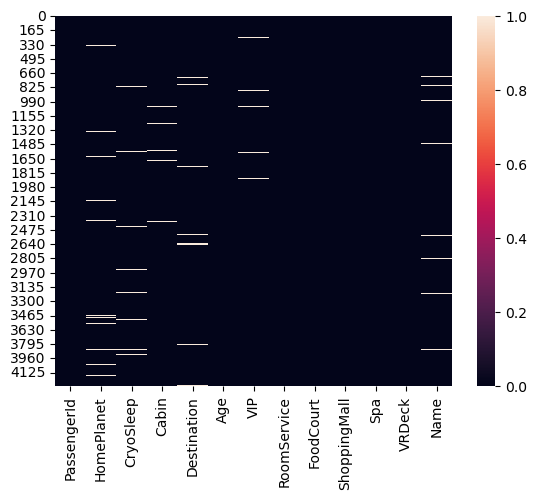

In [35]:
sns.heatmap(X_test.isna())

now will proceed to impute the validation dataset using Austin's imputation method.

In [31]:

X_valid[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']] = X_valid[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].interpolate(method='linear')
X_valid

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
304,0337_02,Mars,False,TRAPPIST-1e,19.0,False,417.0,349.0,634.0,3.0,1057.0,F,63,S
2697,2891_01,Earth,False,TRAPPIST-1e,18.0,False,4.0,904.0,0.0,0.0,1.0,G,460,S
8424,8998_01,Earth,True,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,G,1449,S
1672,1771_01,Earth,False,TRAPPIST-1e,35.0,False,0.0,338.0,436.0,0.0,0.0,G,291,P
8458,9034_02,Europa,True,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,D,288,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,7585_04,Europa,True,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,C,281,S
3880,4166_01,Europa,True,55 Cancri e,45.0,False,0.0,0.0,0.0,0.0,0.0,B,132,P
6481,6839_01,Earth,False,TRAPPIST-1e,36.0,False,1912.0,0.0,0.0,2.0,0.0,F,1307,S
63,0067_03,Earth,False,55 Cancri e,21.0,False,1946.0,37.0,0.0,0.0,24.0,F,15,S


now will do the same to X_test

In [43]:

X_test[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']] = X_test[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].interpolate(method='linear')
X_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0
4274,9271_01,Mars,True,D/296/P,55 Cancri e,42.333333,False,0.0,0.0,0.0,0.0,0.0
4275,9273_01,Europa,False,D/297/P,NaN,42.666667,False,0.0,2680.0,0.0,0.0,523.0


i think ill remove the name column as it is unnecessary

In [42]:
X_test.drop("Name",axis=1,inplace=True)
X_test

KeyError: "['Name'] not found in axis"